In [438]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

In [439]:
import os
results = np.load('/Users/sean/Desktop/college/intern/2D Wall/2D_Wall_Propped.npy')

In [440]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.05

width = 5   # m
depth = 8   # m
t = 0.1     # m
D =  E * t**3 / (12 * (1 - nu**2))

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

z_dense_lim1, z_dense_lim2 = 1.5, 3.5
x_dense_lim1, x_dense_lim2 = 1.5, 3.5

def is_in_dense_region(z, x):
    return (z_dense_lim1 <= z) & (z <= z_dense_lim2) & (x_dense_lim1 <= x) & (x <= x_dense_lim2)

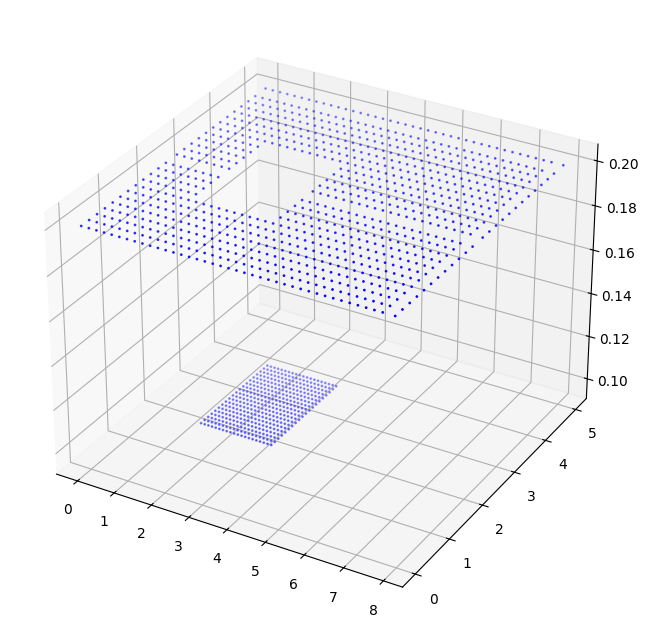

In [441]:
x_raw, z_raw, y_raw = np.split(results, 3, axis = -1)
x_raw_flatten, z_raw_flatten, y_raw_flatten = x_raw.flatten(), z_raw.flatten(), y_raw.flatten()

zdim = 40
xdim = int(zdim / depth * width)
z_sample_index = np.linspace(0, zdim_raw-1, zdim, dtype=int)
x_sample_index = np.linspace(0, xdim_raw-1, xdim, dtype=int)

z_sampled_raw = np.zeros_like(z_raw)
x_sampled_raw = np.zeros_like(x_raw)
y_sampled_raw = np.zeros_like(y_raw)

delta_z , delta_x = [], []

for z_in in range(x_raw.shape[0]):
    for x_in in range(x_raw.shape[1]):
        z, x, y = z_raw[z_in, x_in], x_raw[z_in, x_in], y_raw[z_in, x_in]
        if is_in_dense_region(z, x):
            z_sampled_raw[z_in, x_in] = z
            x_sampled_raw[z_in, x_in] = x
            y_sampled_raw[z_in, x_in] = y
            delta_z.append(depth / zdim_raw)
            delta_x.append(width / xdim_raw)
        else:
            if (not is_in_dense_region(z,x) and (z_in in z_sample_index) and (x_in in x_sample_index)):
                z_sampled_raw[z_in, x_in] = z
                x_sampled_raw[z_in, x_in] = x
                y_sampled_raw[z_in, x_in] = y
                delta_z.append(depth / zdim)
                delta_x.append(width / xdim)
            else:
                z_sampled_raw[z_in, x_in] = np.nan
                x_sampled_raw[z_in, x_in] = np.nan
                y_sampled_raw[z_in, x_in] = np.nan
                

z_sampled_flatten = z_sampled_raw.flatten()
x_sampled_flatten = x_sampled_raw.flatten()
y_sampled_flatten = y_sampled_raw.flatten()

z_flatten = z_sampled_flatten[~np.isnan(z_sampled_flatten)]
x_flatten = x_sampled_flatten[~np.isnan(x_sampled_flatten)]
y_flatten = y_sampled_flatten[~np.isnan(y_sampled_flatten)]

z_max = np.max(z_raw[:,0])
x_max = np.max(x_raw[0])
y_max = np.max(abs(y_raw))


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_flatten, x_flatten, delta_x, c='b', marker='o', s=1)

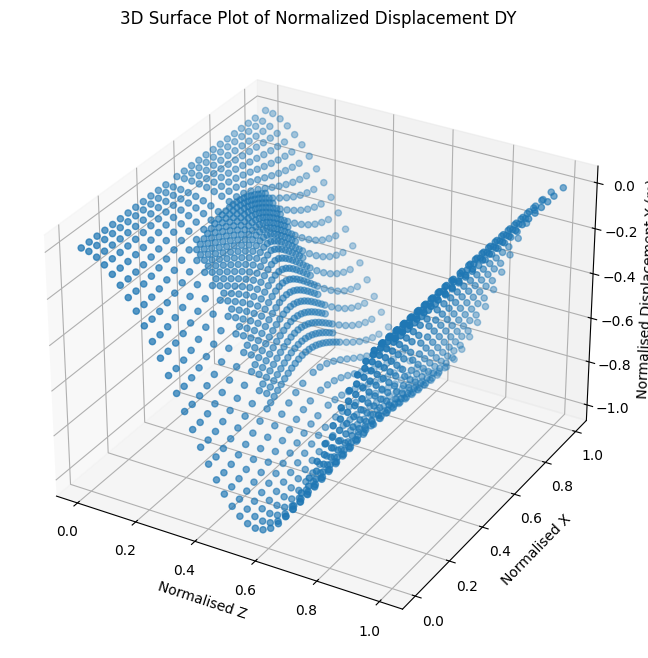

In [442]:
z_norm_flatten = z_flatten / z_max
x_norm_flatten = x_flatten / x_max
y_norm_flatten = y_flatten / y_max

z_norm_flatten_tf = tf.convert_to_tensor(z_norm_flatten, dtype=tf.float32)
x_norm_flatten_tf = tf.convert_to_tensor(x_norm_flatten, dtype=tf.float32)
y_norm_flatten_tf = tf.convert_to_tensor(y_norm_flatten, dtype=tf.float32)

delta_z = np.array(delta_z)
delta_x = np.array(delta_x)

results_norm_flatten = np.stack((z_norm_flatten, x_norm_flatten, y_norm_flatten, delta_z, delta_x), axis = -1)
results_norm_flatten_tf = tf.convert_to_tensor(results_norm_flatten, dtype=tf.float32)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(z_norm_flatten, x_norm_flatten, y_norm_flatten)
ax.set_xlabel('Normalised Z')
ax.set_ylabel('Normalised X')
ax.set_zlabel('Normalised Displacement Y (m)')
ax.set_title('3D Surface Plot of Normalized Displacement DY')

plt.show()

In [443]:
def q_soil_smooth(z, width=0.2):

    # Lines on either side of the break
    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)
def gaussian_prop(z, x, force, xc = width/2, zc = z_prop, sigma = 1e-2):

    phi = force * tf.exp(-((x - xc)**2 + (z - zc)**2) / (2 * sigma**2))
    scale = 1 / (sigma * np.sqrt(2 * np.pi))
    
    return scale * phi

q_s = q_soil_smooth(z_norm_flatten)
q_max = max(q_s)
q_norm = q_s / q_max


In [444]:
model = keras.Sequential([
    keras.layers.Input(shape = (2,)),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

In [445]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


physics loss

In [446]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 / z_max**2 + dx2 / x_max**2

def first_order_grad(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = model(inputs)
    dz, dx = tf.unstack(tape.gradient(f, inputs), axis = -1)
    dz = dz / z_max
    dx = dx / x_max
    g = tf.stack((dz, dx), axis = -1)
    return g

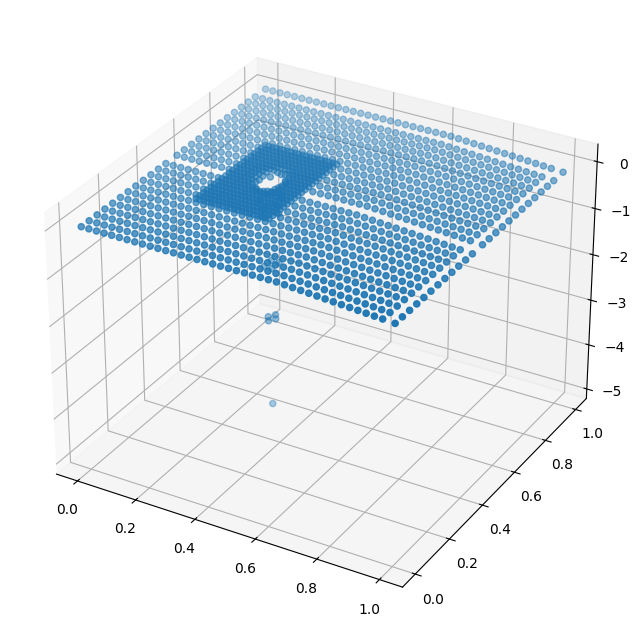

In [ ]:
def gaussian_2D(z, x, force, deltaz, deltax, xc = x_prop, zc = z_prop, sigma = 0.1):

  dtype = z.dtype
  force, xc, zc, sigma = tf.cast(force, dtype), tf.cast(xc, dtype), tf.cast(zc, dtype), tf.cast(sigma, dtype)

  r2 = ((x - xc)**2 + (z - zc)**2) / (2 * sigma**2)
  phi = tf.exp(-r2)
  scale = force / (tf.reduce_sum(phi) * deltax * deltaz)
  d2 = (x - tf.cast(xc,dtype))**2 + (z - tf.cast(zc,dtype))**2

  return scale * phi

def piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, deltaz, deltax):  #input normalized
    z_phys = z_norm_flatten_tf * z_max
    
    q_s = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    q_prop = gaussian_2D(z_phys, x_norm_flatten_tf * x_max, zR_prop, deltaz, deltax)
    
    return q_s - q_prop
  
delta_z_tf = tf.convert_to_tensor(delta_z, dtype=tf.float32)
delta_x_tf = tf.convert_to_tensor(delta_x, dtype=tf.float32)  

q_test = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z_tf, delta_x_tf)
fig.add_axes(ax)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_norm_flatten, x_norm_flatten, q_test)

In [448]:
N_DATA_ONLY_EPOCHS = 2000
N_BC_EPOCHS = 1000
N_PHYSICS_EPOCHS = 2000

@tf.function

def train_step(batch, epoch_val):
  z, x , y_true , deltaz, deltax= batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
  with tf.GradientTape() as tape:
    zxstack = tf.stack((z, x), axis = -1)
    y_pred = model(zxstack)
    y_pred = tf.squeeze(y_pred, -1)  # Ensure y_pred is 1D
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    y_at_z_boundaries = tf.where(z < (1 / zdim), y_pred, 0.0) + tf.where((1 - z) < (1 / zdim), y_pred, 0.0)
    bc_disp = tf.reduce_mean(tf.square(y_at_z_boundaries))
    
    gradz, gradx = tf.unstack(first_order_grad(zxstack), axis = -1)
    gradz_at_z_boundaries = tf.where(z < (1 / zdim), gradz, 0.0) + tf.where((1 - z) < (1 / zdim), gradz, 0.0)
    bc_z_loss = tf.reduce_mean(tf.square(gradz_at_z_boundaries))
    
    gradx_at_x_boundaries = tf.where(x < (1 / xdim), gradx, 0.0) + tf.where((1 - x) < (1 / xdim), gradx, 0.0)
    bc_x_loss = tf.reduce_sum(tf.square(gradx_at_x_boundaries)) 
    
    bc_loss = bc_disp + bc_z_loss + bc_x_loss
      
    biharmonic = laplacian(zxstack, laplacian)
    q_pred = piecewise_q(z, x, deltaz, deltax)
    physics_residual = tf.square(biharmonic * D * y_max / q_max - q_pred / q_max)
    physics_loss = tf.reduce_mean(physics_residual)

    if epoch_val < N_DATA_ONLY_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.0, 0.2
    elif epoch_val < N_BC_EPOCHS:
        w_data, w_phys, w_bc = 0.2, 0.5, 0.1
    else:
        w_data, w_phys, w_bc = 1.0, 0.1, 0.2
        
    loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

  variables = model.trainable_variables + [m_a, m_p]
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del tape
  return loss, data_loss, bc_loss, physics_loss


In [449]:
def snapshot(model):
    snap = keras.models.clone_model(model)
    snap.build(model.input_shape)
    snap.set_weights(model.get_weights())
    return snap

In [450]:
# --- 0. batching parameters --------------------------------------------
BATCH_SIZE  = 1024
SHUFFLE_BUF = 10_000

model_phase1, model_phase2 = model, model

dataset = (tf.data.Dataset.from_tensor_slices(
              results_norm_flatten_tf)
           .shuffle(SHUFFLE_BUF, reshuffle_each_iteration=True)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

# --- 1. history containers ---------------------------------------------
history        = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_params = {"m_a": [], "m_p": []}

In [451]:
# --- 2. training loop ---------------------------------------------------
for epoch in range(5000):
    # We’ll keep the metrics from the *last* batch in this epoch
    for batch in dataset:
        loss, data_l, bc_l, phys_l = train_step(batch, tf.cast(epoch, tf.int32))

    # record those metrics (no division → no ZeroDivisionError)
    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | "
              f"loss {loss.numpy():.3e} | "
              f"data {data_l.numpy():.3e} | "
              f"bc {bc_l.numpy():.3e} | "
              f"phys {phys_l.numpy():.3e}")
    
    if epoch == N_DATA_ONLY_EPOCHS - 1:
        model_phase1 = snapshot(model)
    if epoch == N_DATA_ONLY_EPOCHS + N_BC_EPOCHS - 1:
        model_phase2 = snapshot(model)


Epoch   0 | loss 2.385e-01 | data 2.385e-01 | bc 2.302e-05 | phys 1.780e+04
Epoch   5 | loss 1.680e-01 | data 1.675e-01 | bc 2.204e-03 | phys 2.646e+04
Epoch  10 | loss 1.009e-01 | data 9.908e-02 | bc 9.226e-03 | phys 2.830e+04
Epoch  15 | loss 1.025e-01 | data 9.869e-02 | bc 1.887e-02 | phys 2.502e+04
Epoch  20 | loss 7.711e-02 | data 7.527e-02 | bc 9.196e-03 | phys 4.568e+04
Epoch  25 | loss 9.434e-02 | data 9.292e-02 | bc 7.084e-03 | phys 4.399e+04
Epoch  30 | loss 8.297e-02 | data 8.165e-02 | bc 6.621e-03 | phys 2.325e+04
Epoch  35 | loss 9.645e-02 | data 9.477e-02 | bc 8.426e-03 | phys 2.060e+04
Epoch  40 | loss 8.743e-02 | data 8.616e-02 | bc 6.333e-03 | phys 2.302e+04
Epoch  45 | loss 9.310e-02 | data 9.013e-02 | bc 1.486e-02 | phys 2.596e+04
Epoch  50 | loss 8.806e-02 | data 8.654e-02 | bc 7.567e-03 | phys 3.464e+04
Epoch  55 | loss 8.623e-02 | data 8.506e-02 | bc 5.869e-03 | phys 3.454e+04
Epoch  60 | loss 9.862e-02 | data 9.657e-02 | bc 1.028e-02 | phys 2.585e+04
Epoch  65 | 

KeyboardInterrupt: 

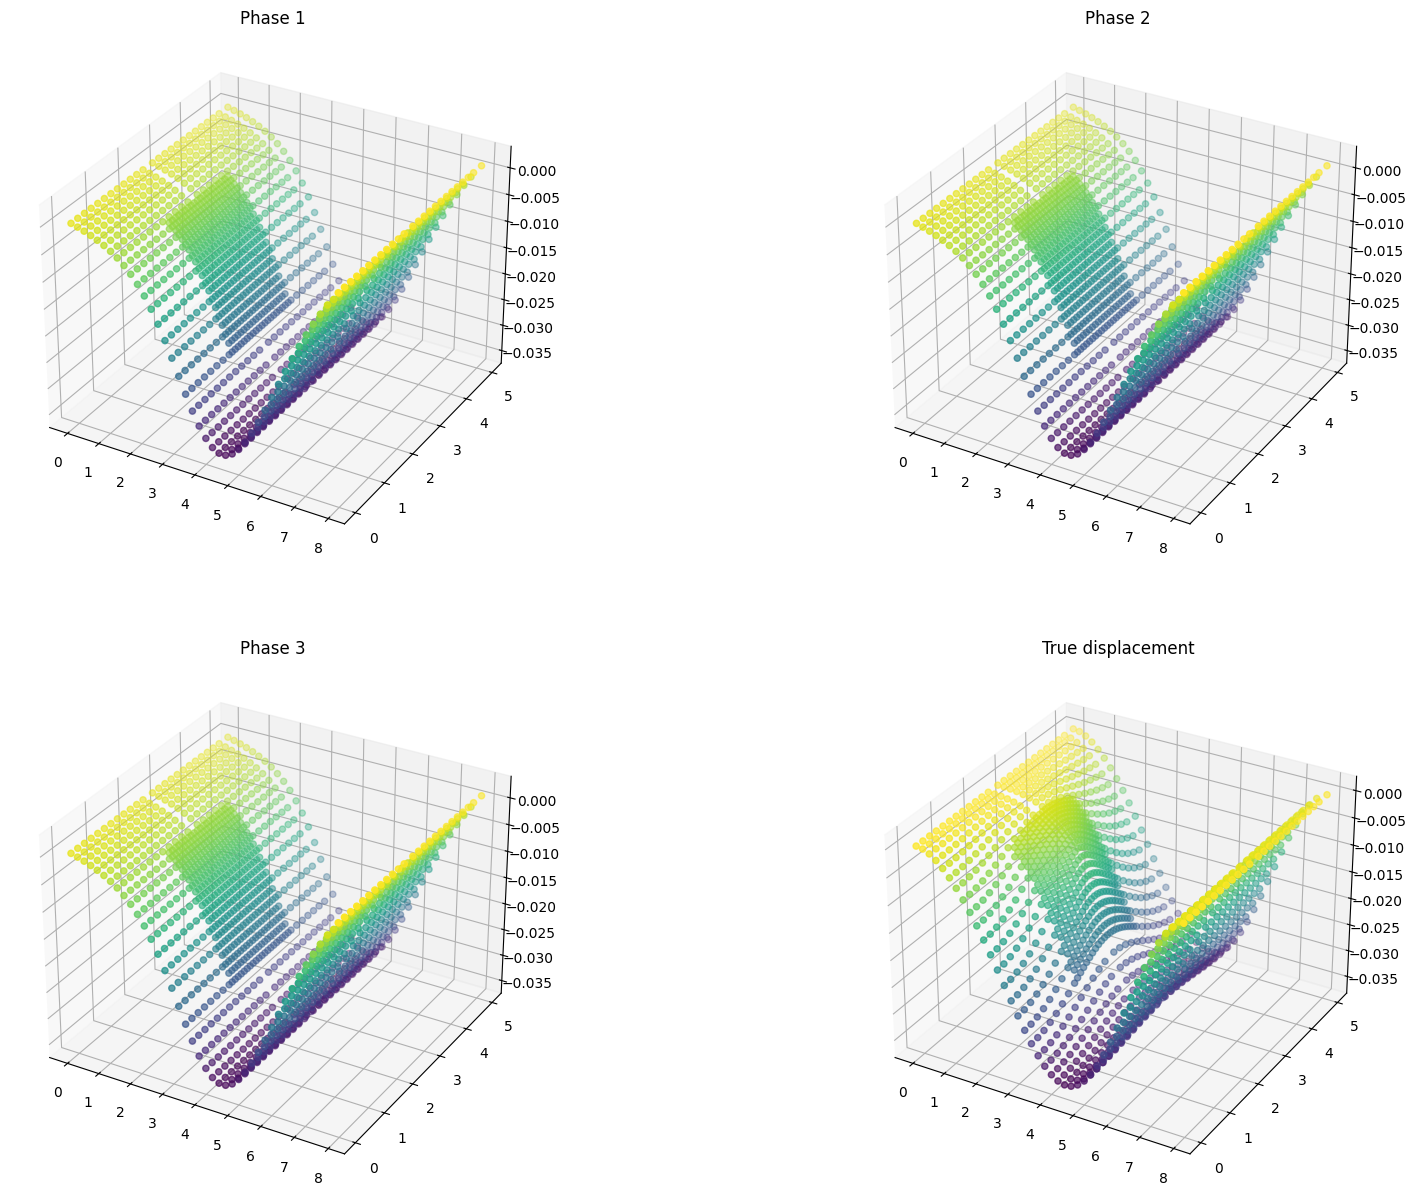

In [452]:

zxstack = tf.stack((z_norm_flatten_tf, x_norm_flatten_tf), axis = -1)

y_pred_norm1 = model_phase1(zxstack)
y_pred_norm1 = np.squeeze(y_pred_norm1, -1)
y_pred1 = y_pred_norm1 * y_max

y_pred_norm2 = model_phase2(zxstack)
y_pred_norm2 = np.squeeze(y_pred_norm2, -1)
y_pred2 = y_pred_norm2 * y_max

y_pred_norm3 = model(zxstack)
y_pred_norm3 = np.squeeze(y_pred_norm3, -1)
y_pred3 = y_pred_norm3 * y_max

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(z_flatten, x_flatten, y_pred1, c = y_pred1, cmap = 'viridis')
ax1.set_title('Phase 1')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(z_flatten, x_flatten, y_pred2, c = y_pred2, cmap='viridis')
ax2.set_title('Phase 2')

ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten, x_flatten, y_pred3, c = y_pred3, cmap = 'viridis')
ax3.set_title('Phase 3')

ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten, x_flatten, y_flatten, c = y_flatten, cmap = 'viridis')
ax4.set_title('True displacement')

plt.show()

0.5 1


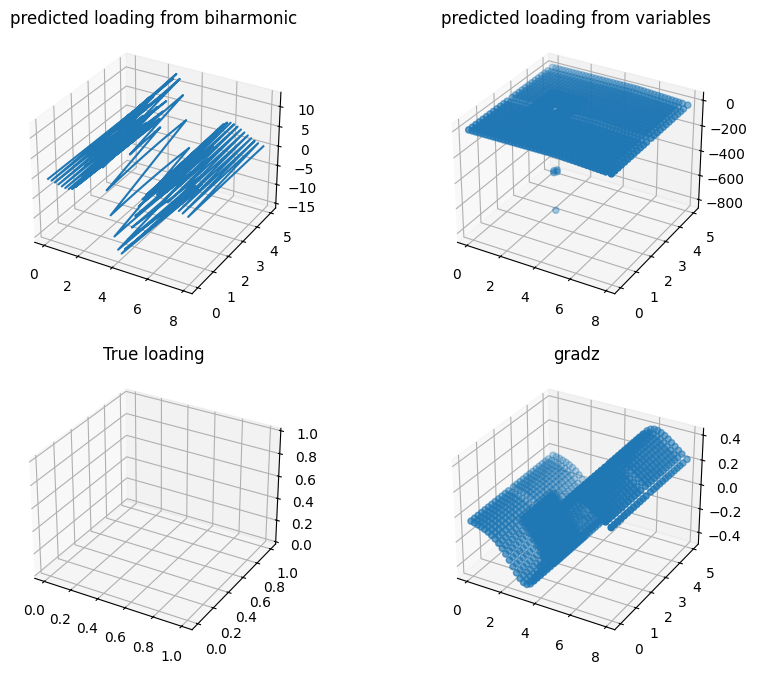

In [454]:
bih = laplacian(zxstack, laplacian)

cut = 0
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.plot(z_flatten[cut*xdim:], x_flatten[cut*xdim:], bih[cut*xdim:]* D * y_max / q_max)
ax1.set_title('predicted loading from biharmonic')

q_params = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z_tf, delta_x_tf)
ax2 = fig.add_subplot(222, projection = '3d')
ax2.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_params[cut*xdim:]/q_max)
ax2.set_title('predicted loading from variables')

q_true = q_soil_smooth(z_flatten) - gaussian_2D(z_flatten, x_flatten, deltaz, deltax, zR_prop)
ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_true[cut*xdim:]/q_max)
ax3.set_title('True loading')

gz, gx = tf.unstack(first_order_grad(zxstack), axis = -1)
ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], gz[cut*xdim:])
ax4.set_title('gradz')
tf.print(m_a, m_p)